In [1]:
# !pip install interpret
# !pip install --user xgboost
# !pip install pytorch-tabnet
# !pip install anchor-exp

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))
df.target = df.target.astype(np.int64)
_class = 'target'
class_names = [0, 1]

In [4]:
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [6]:
X, y = df.drop(columns=[_class]), df[_class]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [8]:
x_test.shape

(171, 30)

In [9]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 149 to 102
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              398 non-null    float64
 1   mean texture             398 non-null    float64
 2   mean perimeter           398 non-null    float64
 3   mean area                398 non-null    float64
 4   mean smoothness          398 non-null    float64
 5   mean compactness         398 non-null    float64
 6   mean concavity           398 non-null    float64
 7   mean concave points      398 non-null    float64
 8   mean symmetry            398 non-null    float64
 9   mean fractal dimension   398 non-null    float64
 10  radius error             398 non-null    float64
 11  texture error            398 non-null    float64
 12  perimeter error          398 non-null    float64
 13  area error               398 non-null    float64
 14  smoothness error        

# ML Model

In [10]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [12]:
random_state=42

In [13]:
x_train

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
149       13.740         17.91           88.12      585.0          0.07944   
124       13.370         16.39           86.10      553.5          0.07115   
421       14.690         13.98           98.22      656.1          0.10310   
195       12.910         16.33           82.53      516.4          0.07941   
545       13.620         23.23           87.19      573.2          0.09246   
..           ...           ...             ...        ...              ...   
71         8.888         14.64           58.79      244.0          0.09783   
106       11.640         18.33           75.17      412.5          0.11420   
270       14.290         16.82           90.30      632.6          0.06429   
435       13.980         19.62           91.12      599.5          0.10600   
102       12.180         20.52           77.22      458.7          0.08013   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
149           0.06376         0.02881              0.01329         0.1473   
124           0.07325         0.08092              0.02800         0.1422   
421           0.18360         0.14500              0.06300         0.2086   
195           0.05366         0.03873              0.02377         0.1829   
545           0.06747         0.02974              0.02443         0.1664   
..                ...             ...                  ...            ...   
71            0.15310         0.08606              0.02872         0.1902   
106           0.10170         0.07070              0.03485         0.1801   
270           0.02675         0.00725              0.00625         0.1508   
435           0.11330         0.11260              0.06463         0.1669   
102           0.04038         0.02383              0.01770         0.1739   

     mean fractal dimension  ...  worst radius  worst texture  \
149                 0.05580  ...        15.340          22.46   
124                 0.05823  ...        14.260          22.75   
421                 0.07406  ...        16.460          18.34   
195                 0.05667  ...        13.880          22.00   
545                 0.05801  ...        15.350          29.09   
..                      ...  ...           ...            ...   
71                  0.08980  ...         9.733          15.67   
106                 0.06520  ...        13.140          29.26   
270                 0.05376  ...        14.910          20.65   
435                 0.06544  ...        17.040          30.80   
102                 0.05677  ...        13.340          32.84   

     worst perimeter  worst area  worst smoothness  worst compactness  \
149            97.19       725.9           0.09711            0.18240   
124            91.99       632.1           0.10250            0.25310   
421           114.10       809.2           0.13120            0.36350   
195            90.81       600.6           0.10970            0.15060   
545            97.58       729.8           0.12160            0.15170   
..               ...         ...               ...                ...   
71             62.56       284.4           0.12070            0.24360   
106            85.51       521.7           0.16880            0.26600   
270            94.44       684.6           0.08567            0.05036   
435           113.90       869.3           0.16130            0.35680   
102            84.58       547.8           0.11230            0.08862   

     worst concavity  worst concave points  worst symmetry  \
149          0.15640               0.06019          0.2350   
124          0.33080               0.08978          0.2048   
421          0.32190               0.11080          0.2827   
195          0.17640               0.08235          0.3024   
545          0.10490               0.07174          0.2642   
..               ...                   ...             ...   
71           0.14340               0.04786         

In [14]:
def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        f1, acc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred)
        data.append([name, f1, acc])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.'])
    df = df.sort_values(by=['F1'])
    return df

In [15]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
_xgb = xgb.XGBClassifier(random_state=random_state)
ebm = ExplainableBoostingClassifier(random_state=random_state)
tbn = TabNetClassifier(verbose=0, seed=random_state)

clfs = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
# clfs = [(rf, 'rf', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
dataset = x_train, y_train, x_test, y_test
classify_report(clfs, dataset)

Name        F1      Acc.
4  tbn  0.507614  0.432749
1  gbc  0.967742  0.959064
2  xgb  0.976744  0.970760
0   rf  0.977169  0.970760
3  ebm  0.981651  0.976608

# XAI

In [16]:
# selected_model = _xgb
# For fairness of comparisions we used RF
selected_model = rf

In [17]:
class_names = ['NO','YES']
feature_names = x_train.columns.to_list()
# local = lime, shap, anchor, tabnet, ebm
# global = pfi, tabnet, ebm, shap
# methods = pfi, tabnet, ebm, shap, lime, anchor
# remaining = pdp, eli5, ice, adawhip, break down

## Noisy test

In [18]:
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

x_test_noisy = add_noise(x_test)
display(x_test_noisy)

mean radius  mean texture  mean perimeter    mean area  mean smoothness  \
204    12.463845     18.599701       81.074252   481.905295         0.110886   
70     18.930598     21.314136      123.603072  1130.002006         0.099200   
131    15.464136     19.463453      101.694213   748.907834         0.105554   
431    12.390654     17.680112       81.461469   467.795076         0.107826   
540    11.538617     14.434505       74.651699   402.885675         0.106004   
..           ...           ...             ...          ...              ...   
69     12.772887     16.501027       81.373956   502.508677         0.107264   
542    14.764816     25.416968       94.696439   668.596560         0.091102   
176     9.911335     18.079137       64.593462   302.385328         0.108489   
501    13.821527     24.489905       92.321213   595.896817         0.111164   
247    12.896173     14.116930       84.952631   512.207246         0.081954   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
204          0.095489        0.096728             0.018582       0.183971   
70           0.118830        0.114653             0.080754       0.152951   
131          0.119692        0.144316             0.083672       0.185071   
431          0.133409        0.101399             0.044328       0.189348   
540          0.114648        0.075676             0.027068       0.186005   
..                ...             ...                  ...            ...   
69           0.035632        0.041986             0.031444       0.165505   
542          0.065556        0.032440             0.025998       0.183281   
176          0.141471        0.135304             0.045923       0.149323   
501          0.159115        0.125352             0.077277       0.213024   
247          0.127434        0.124021             0.035249       0.146254   

     mean fractal dimension  ...  worst radius  worst texture  \
204                0.076607  ...     14.984086      24.648475   
70                 0.054307  ...     24.863129      26.591442   
131                0.053584  ...     19.252970      26.001847   
431                0.070952  ...     12.898746      22.907906   
540                0.058645  ...     12.253872      19.675271   
..                      ...  ...           ...            ...   
69                 0.056585  ...     13.459264      19.758989   
542                0.044249  ...     16.515968      32.300772   
176                0.069638  ...     11.265458      24.386199   
501                0.088658  ...     16.015246      32.936466   
247                0.074596  ...     14.389812      17.696144   

     worst perimeter   worst area  worst smoothness  worst compactness  \
204        96.063903   677.905307          0.133564           0.256235   
70        165.904228  1865.996989          0.114544           0.244621   
131       124.903466  1155.996719          0.147324           0.243483   
431        89.622957   515.776159          0.133167           0.267481   
540        78.776656   457.825158          0.155802           0.218596   
..               ...          ...               ...                ...   
69         85.665334   554.903664          0.140623           0.084088   
542       107.393699   826.397063          0.114422           0.135715   
176        73.059582   390.196853          0.126691           0.284692   
501       105.992434   787.986273          0.188381           0.389341   
247       104.989134   639.099624          0.133334           0.568540   

     worst concavity  worst concave points  worst symmetry  \
204         0.264270              0.080283        0.290362   
70          0.263949              0.174125        0.254776   
131         0.375176              0.146790        0.290082   
431         0.247780              0.081352        0.241991   
540         0.171839              0.062218        0.221213   
..               ...                   ...             ...   
69          0.0

## Local

In [19]:
import lime
from lime import lime_tabular
exp_lime=lime_tabular.LimeTabularExplainer(np.array(x_train),feature_names=x_train.columns,class_names=['NO','YES'],mode='classification')

import shap
shap.plots.initjs()

exp_shap = shap.TreeExplainer(selected_model)

from anchor import anchor_tabular

exp_anchor = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    x_train.values[:,:],
    {})

def get_tbn_local_graph(exp_tn_mat, idx, feature_names):
    m = exp_tn_mat[idx]>0
    ax = pd.Series(exp_tn_mat[idx][m], index=np.array(feature_names)[m]).sort_values(ascending=True).plot.barh()
    ax.set_title("TabNet Feature Importance")
    ax.figure.tight_layout()
    plt.show()

def show_outputs(dataset, _id):
    exp_lime.explain_instance(dataset.iloc[_id,:], selected_model.predict_proba).show_in_notebook(show_all=True)
    shap.plots.waterfall(exp_shap(dataset.iloc[_id:_id+1])[0,:,_prediction], max_display=10)
    preserve(ebm.explain_local(dataset.iloc[_id:_id+1], y_test.iloc[_id:_id+1], name='EBM'), 0)
    get_tbn_local_graph(tbn.explain(dataset.iloc[_id:_id+1].values)[0], 0, feature_names)
    
    exp = exp_anchor.explain_instance(dataset.iloc[_id, :].values, selected_model.predict, threshold=0.99)
    print('  >> Anchor: %s' % (' AND '.join(exp.names())))

In [20]:
def show_data_using_ids(ids_to_explain_list):
    print('Original')
    display(x_test.iloc[ids_to_explain_list])
    print('Noisy')
    display(x_test_noisy.iloc[ids_to_explain_list])
    print('Predictions')
    display(y_test.iloc[ids_to_explain_list])

In [21]:
ids_to_explain_list = [2, 3]

Original


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
131        15.46         19.48          101.70      748.9           0.1092   
431        12.40         17.68           81.47      467.8           0.1054   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
131            0.1223         0.14660              0.08087         0.1931   
431            0.1316         0.07741              0.02799         0.1811   

     mean fractal dimension  ...  worst radius  worst texture  \
131                 0.05796  ...         19.26          26.00   
431                 0.07102  ...         12.88          22.91   

     worst perimeter  worst area  worst smoothness  worst compactness  \
131           124.90      1156.0            0.1546             0.2394   
431            89.61       515.8            0.1450             0.2629   

     worst concavity  worst concave points  worst symmetry  \
131           0.3791                0.1514          0.2837   
431           0.2403                0.0737          0.2556   

     worst fractal dimension  
131                  0.08019  
431                  0.09359  

[2 rows x 30 columns]

Noisy


mean radius  mean texture  mean perimeter   mean area  mean smoothness  \
131    15.464136     19.463453      101.694213  748.907834         0.105554   
431    12.390654     17.680112       81.461469  467.795076         0.107826   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
131          0.119692        0.144316             0.083672       0.185071   
431          0.133409        0.101399             0.044328       0.189348   

     mean fractal dimension  ...  worst radius  worst texture  \
131                0.053584  ...     19.252970      26.001847   
431                0.070952  ...     12.898746      22.907906   

     worst perimeter   worst area  worst smoothness  worst compactness  \
131       124.903466  1155.996719          0.147324           0.243483   
431        89.622957   515.776159          0.133167           0.267481   

     worst concavity  worst concave points  worst symmetry  \
131         0.375176              0.146790        0.290082   
431         0.247780              0.081352        0.241991   

     worst fractal dimension  
131                 0.079108  
431                 0.088154  

[2 rows x 30 columns]

Predictions


131    0
431    1
Name: target, dtype: int64

ID 2 Prediction:  0
> Original


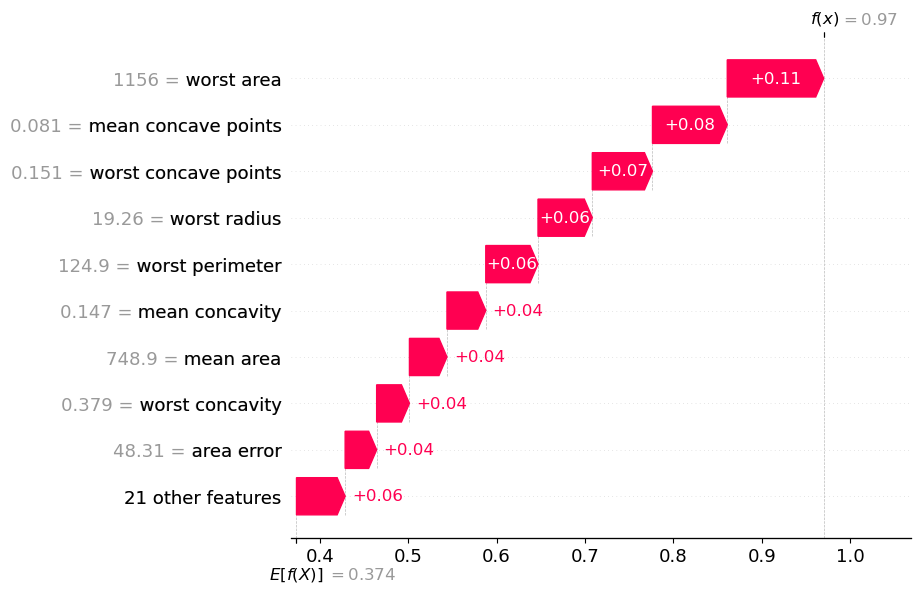

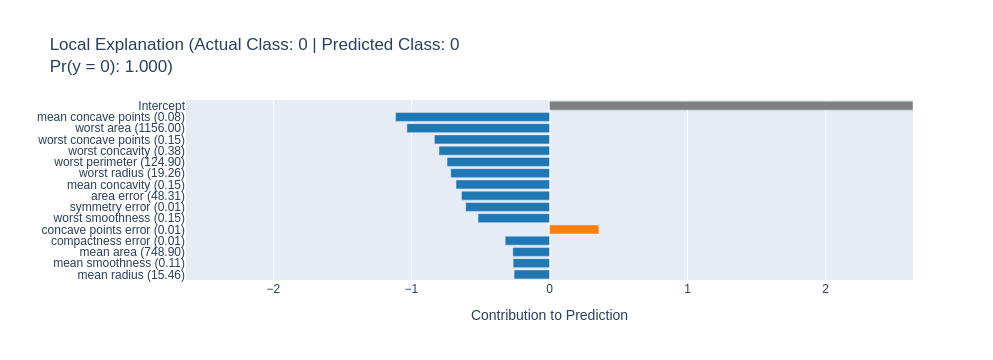

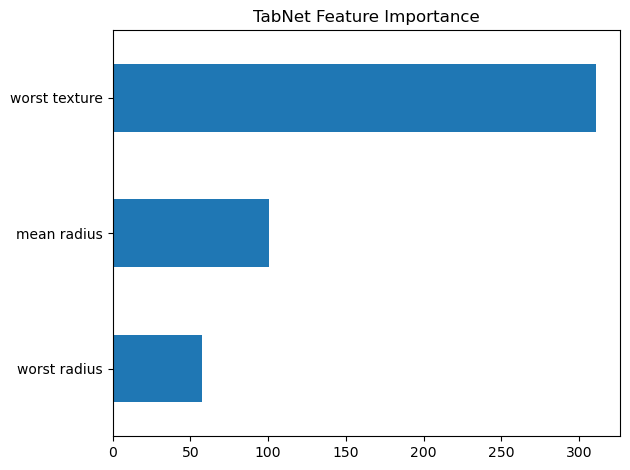

  >> Anchor: perimeter error <= 3.28 AND worst area > 1061.25 AND smoothness error > 0.01
> Noisy


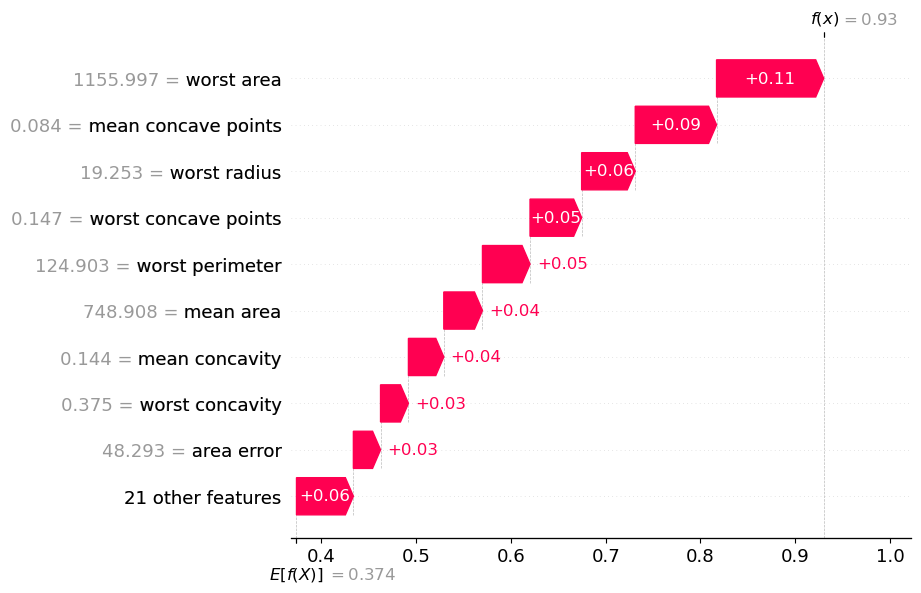

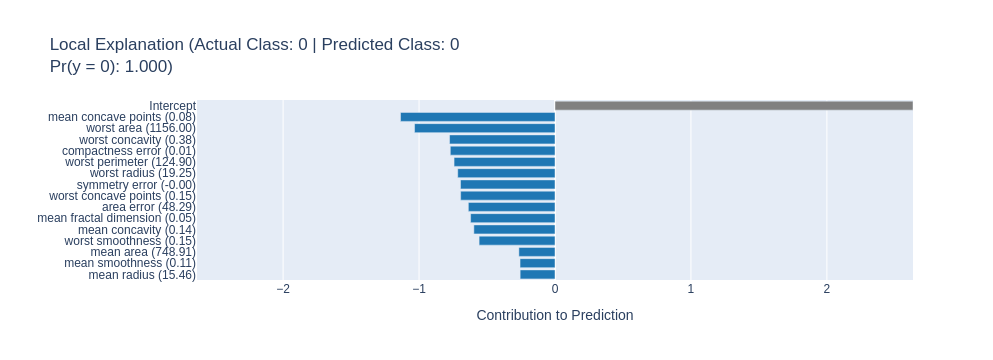

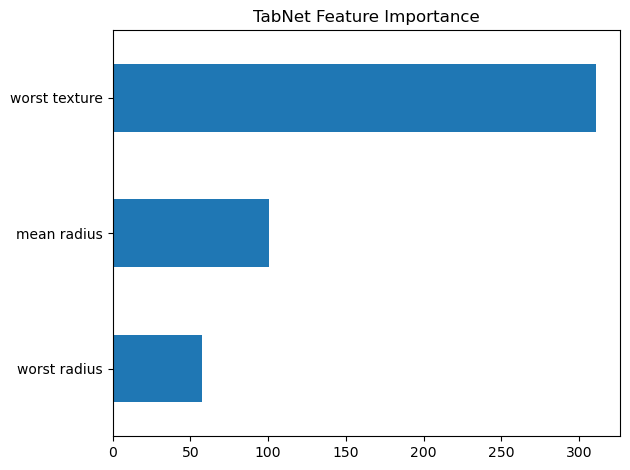

  >> Anchor: concavity error > 0.02 AND worst area > 1061.25 AND worst compactness > 0.15
ID 3 Prediction:  1
> Original


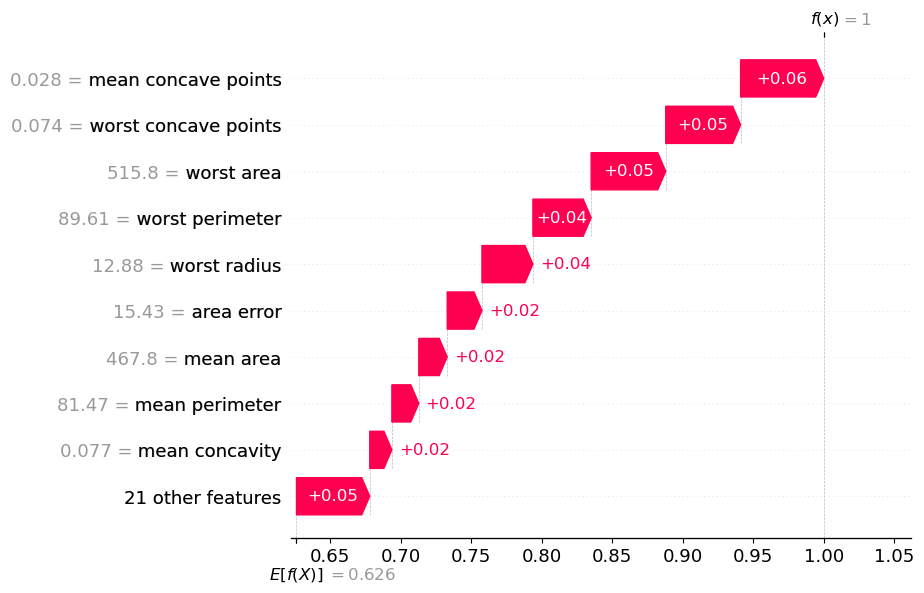

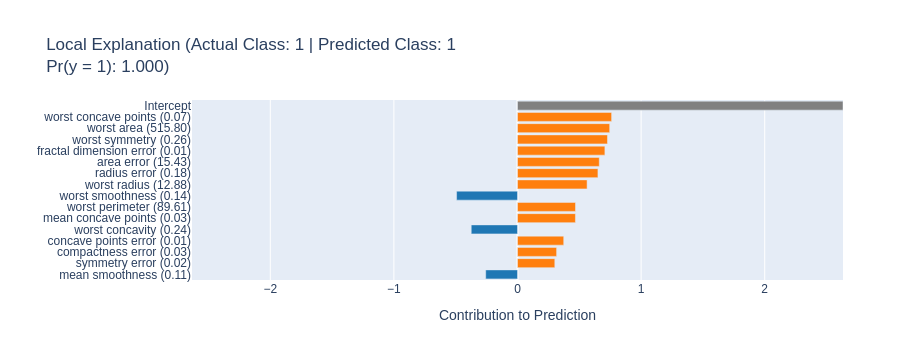

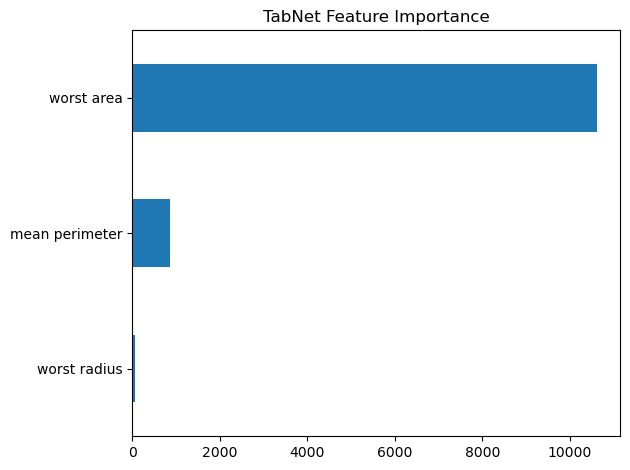

  >> Anchor: mean concave points <= 0.03 AND worst radius <= 13.07
> Noisy


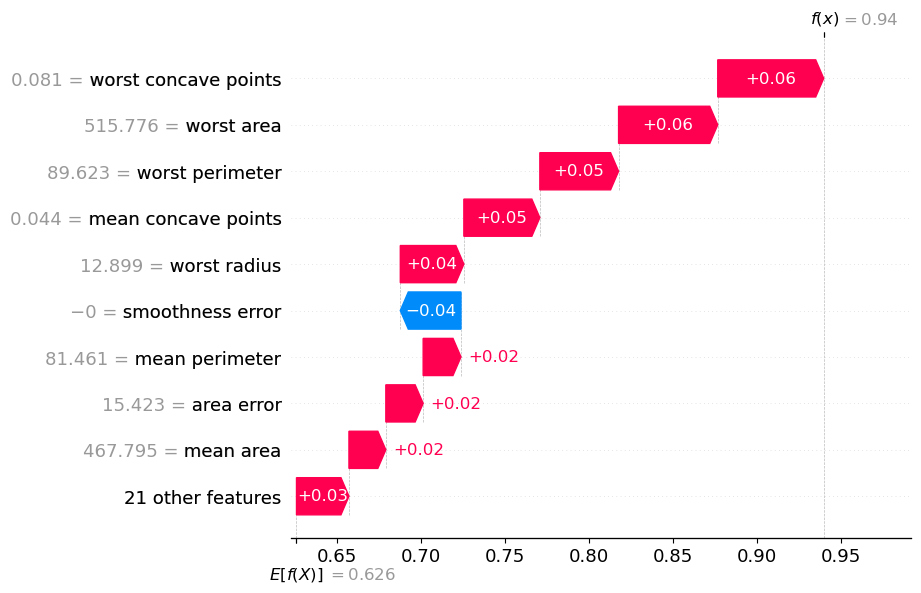

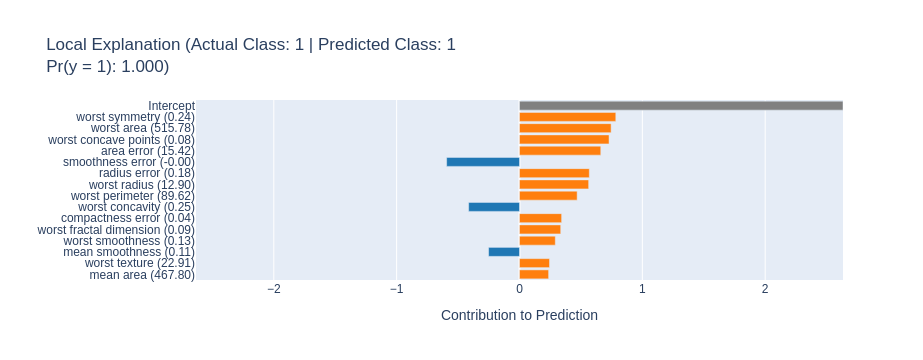

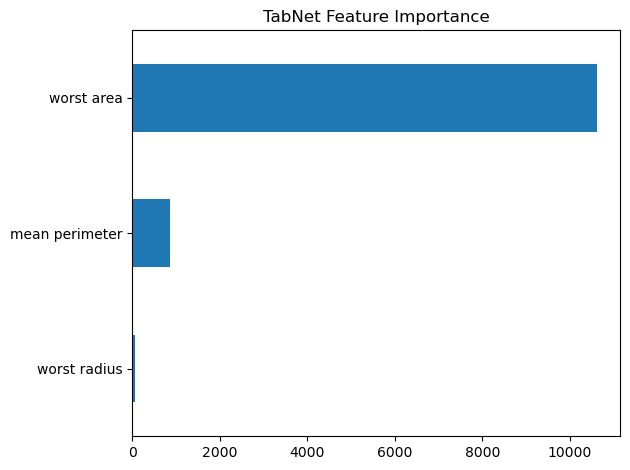

  >> Anchor: mean concavity <= 0.13 AND worst radius <= 13.07


In [22]:
np.random.seed(random_state)
show_data_using_ids(ids_to_explain_list)
for _id in ids_to_explain_list:
    _prediction = y_test.iloc[_id]
    print('ID', _id,  'Prediction: ', _prediction)

    # Original explanation cases
    # Noisy explanation to compare how the rule (features in the rule) changes due to insertion of Noise
    for msg, dataset in [('Original', x_test), ('Noisy', x_test_noisy)]:
        print('>', msg)
        show_outputs(dataset, _id)

## Global

### PMI

Elapsed time to compute the importances: 0.933 seconds


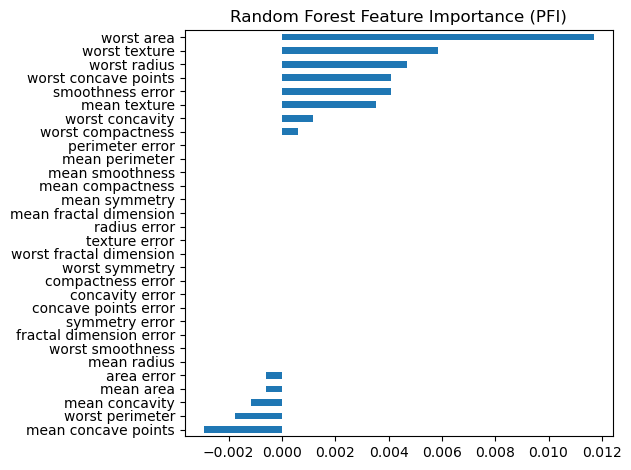

In [23]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    selected_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

selected_model_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=True)

ax = selected_model_importances.plot.barh()
ax.set_title("Random Forest Feature Importance (PFI)")
ax.figure.tight_layout()

### TABNET

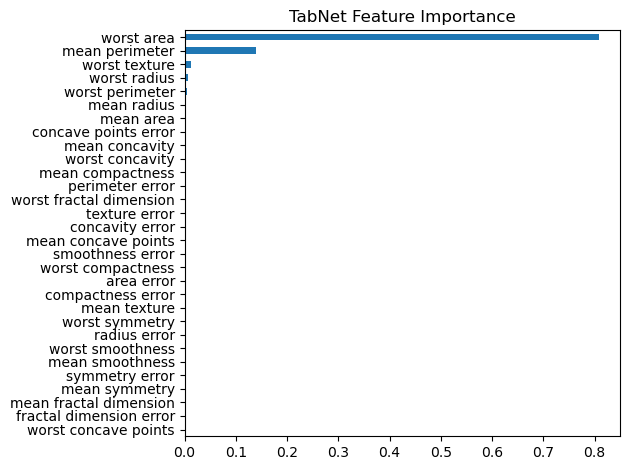

In [24]:
ax = pd.Series(tbn.feature_importances_, index=feature_names).sort_values(ascending=True).plot.barh()
ax.set_title("TabNet Feature Importance")
ax.figure.tight_layout()

### EBM

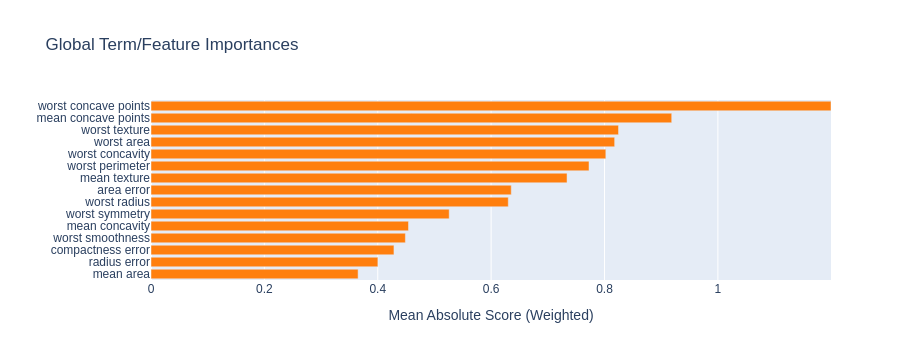

In [25]:
ebm_global = ebm.explain_global()
# show(ebm_global)

# Replace show with the preserve.

# ebm_global = ebm.explain_global(name='EBM')
# show(ebm_global)

# preserve(ebm_global, file_name='output/global-graph.html')
preserve(ebm_global)

### SHAP

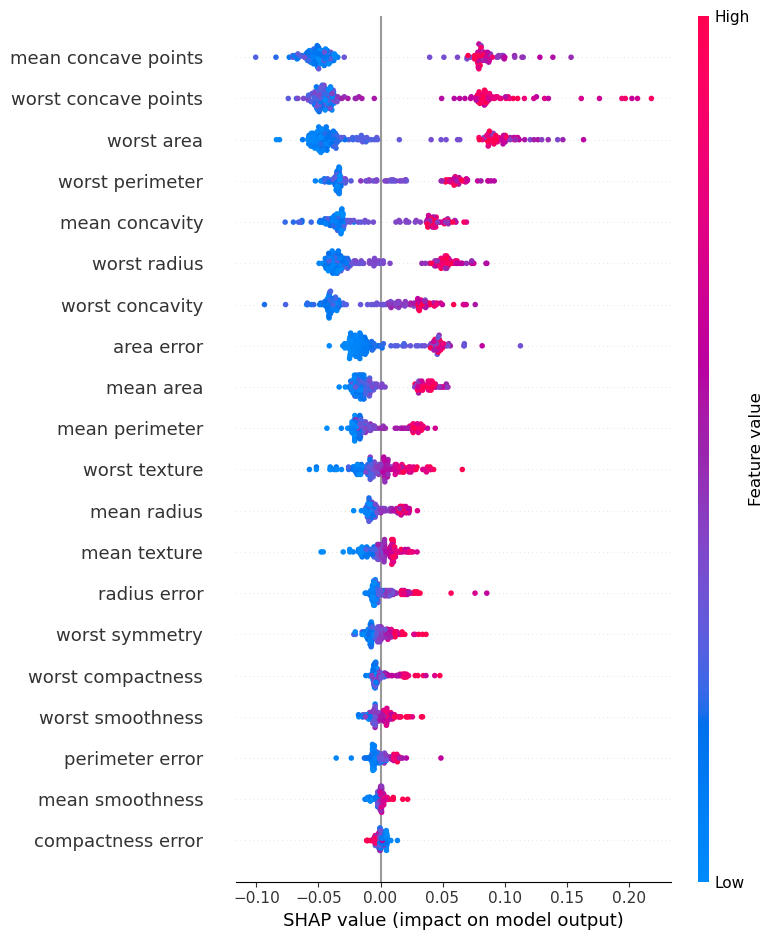

In [26]:
shap_values = exp_shap.shap_values(x_test)
shap.summary_plot(shap_values[:,:,0], x_test)
# shap.summary_plot(shap_values[:,:,0], X_test)

In [27]:
# f.savefig("summary_plot_CS.png", bbox_inches='tight', dpi=600)